In [1]:
# ============================================
# [1/6] IMPORT ALL LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, accuracy_score, precision_score, recall_score, f1_score)

import warnings
warnings.filterwarnings('ignore')

print("[1/6] Libraries imported...")


[1/6] Libraries imported...


In [2]:
# ============================================================================
# [2/6] LOAD  DATA
# ============================================================================
print("[2/6] Loading data...")

# Load your data
df = pd.read_csv(r'C:\Users\hp\Desktop\Dataset\telecom_churn.csv') 

print(f"✓ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

print("✓ Data types:")
df.info()


[2/6] Loading data...
✓ Data loaded: 7043 rows, 23 columns
✓ Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract        

In [3]:
# ============================================================================
# [3/6] DATA CLEANING
# ============================================================================
print("\n[3/6] Cleaning data...")

# Standardize column names
df.columns = (
    df.columns.str.lower()
    .str.strip()
    .str.replace(' ', '_')
)

# Convert TotalCharges to numeric (handle spaces)
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

# Convert dates
df['signupdate'] = pd.to_datetime(df['signupdate'], errors='coerce')
df['churndate'] = pd.to_datetime(df['churndate'], errors='coerce')


# Calculate additional features
df['avg_monthly_spend'] = df['totalcharges'] / (df['tenure'] + 1)
df['price_sensitivity'] = df['monthlycharges'] / df['avg_monthly_spend']
df['tenuregroup'] = pd.cut(
    df['tenure'], 
    bins=[0, 6, 12, 24, 999],
    labels=['0-6 months', '6-12 months', '12-24 months', '24+ months']
)

print(f"✓ Created 3 engineered features")



[3/6] Cleaning data...
✓ Created 3 engineered features



[3/6] Performing EDA with Churn Risk Segmentation...

✓ Basic Churn Statistics
Total Customers: 7,043
Active Customers: 5,174 (73.5%)
Churned Customers: 1,869 (26.5%)
Overall Churn Rate: 26.54%
Retention Rate: 73.46%

✓ Revenue Analysis
Total MRR: $456,116.60
Active MRR: $316,985.75
Churned MRR (Lost): $139,130.85
Monthly Revenue Churn: 30.50%
Annual Revenue Lost: $1,669,570.20
Average Revenue Per User (ARPU):
  Active: $61.27/month
  Churned: $74.44/month
Total ARR: $16,056,168.70
Active ARR: $13,193,241.80
Churned ARR (Lost): $2,862,926.90

✓ Numerical Features Summary
            tenure  monthlycharges  totalcharges  avg_monthly_spend  \
count  7043.000000     7043.000000   7032.000000        7032.000000   
mean     32.371149       64.761692   2283.300441          59.083067   
std      24.559481       30.090047   2266.771362          30.514438   
min       0.000000       18.250000     18.800000           9.183333   
25%       9.000000       35.500000    401.450000          26.22594

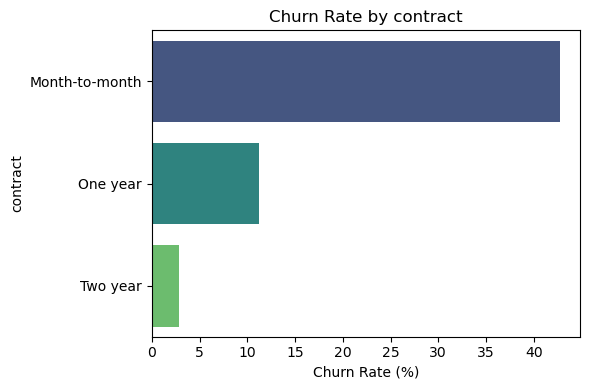


paymentmethod:
  Electronic check: 45.3%
  Mailed check: 19.1%
  Bank transfer (automatic): 16.7%
  Credit card (automatic): 15.2%


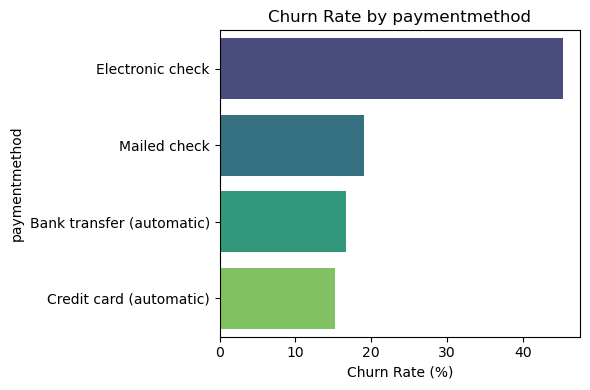


internetservice:
  Fiber optic: 41.9%
  DSL: 19.0%
  No: 7.4%


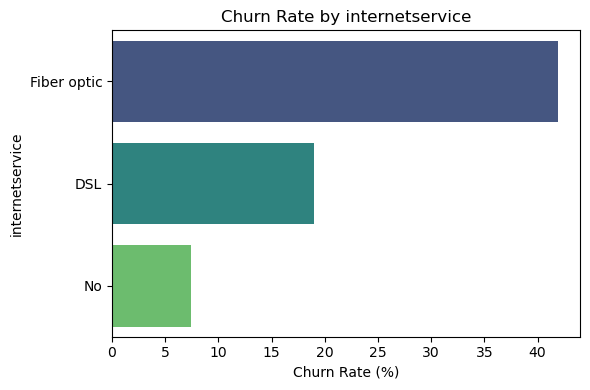


techsupport:
  No: 41.6%
  Yes: 15.2%
  No internet service: 7.4%


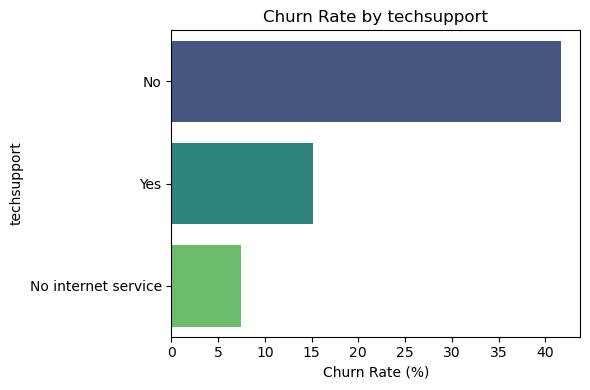


tenuregroup:
  0-6 months: 53.3%
  6-12 months: 35.9%
  12-24 months: 28.7%
  24+ months: 14.0%


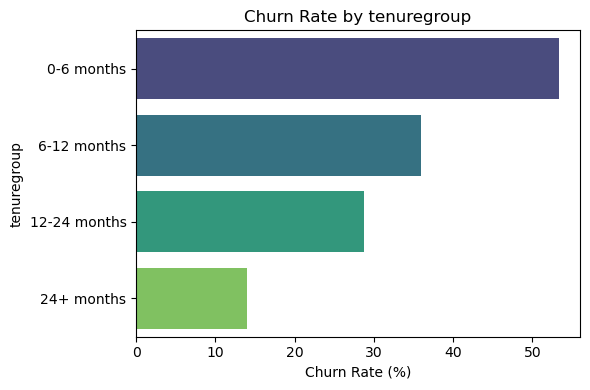


onlinesecurity:
  No: 41.8%
  Yes: 14.6%
  No internet service: 7.4%


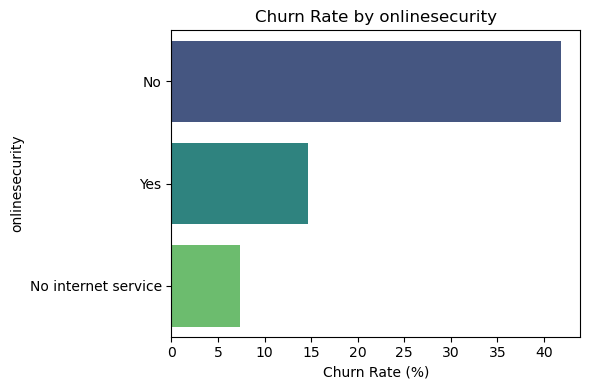


✓ Correlation with Churn (Numerical Features)
price_sensitivity    0.313150
monthlycharges       0.193356
avg_monthly_spend    0.070992
totalcharges        -0.199484
tenure              -0.352229
Name: Churn_Binary, dtype: float64


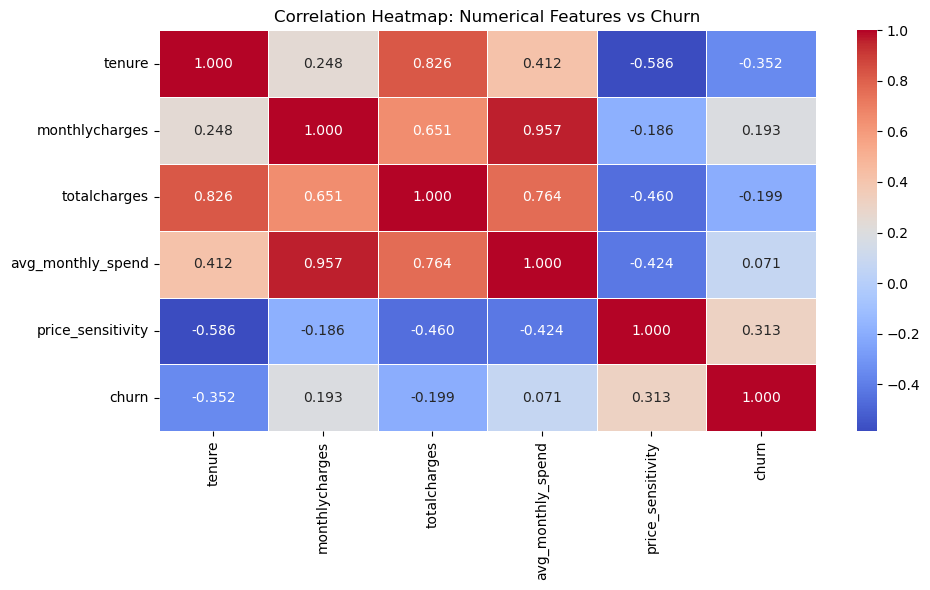

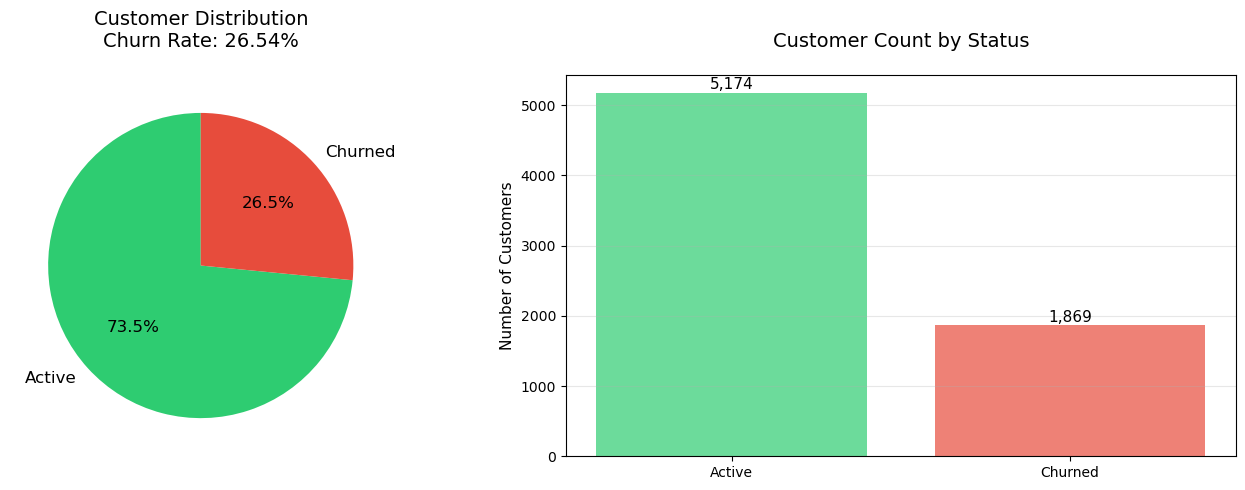

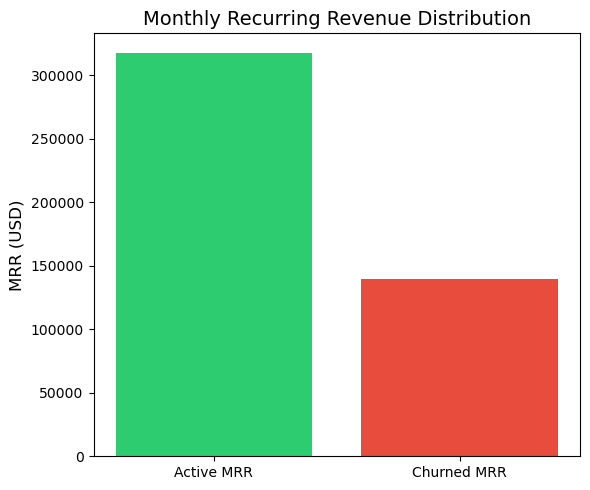


[3/6] EDA with Churn Risk Segmentation & Quick Visuals Complete!



In [4]:
# ============================================================================
# [3/6] EXPLORATORY DATA ANALYSIS (EDA) with Churn Risk Segmentation & Quick Visuals
# ============================================================================
print("\n[3/6] Performing EDA with Churn Risk Segmentation...")

# -----------------------------
# BASIC CHURN STATISTICS
# -----------------------------
total_customers = len(df)
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})
churned_customers = df['churn'].sum()
active_customers = total_customers - churned_customers
churn_rate = df['churn'].mean() * 100
retention_rate = 100 - churn_rate

print("\n" + "="*50)
print("✓ Basic Churn Statistics")
print("="*50)
print(f"Total Customers: {total_customers:,}")
print(f"Active Customers: {active_customers:,} ({retention_rate:.1f}%)")
print(f"Churned Customers: {churned_customers:,} ({churn_rate:.1f}%)")
print(f"Overall Churn Rate: {churn_rate:.2f}%")
print(f"Retention Rate: {retention_rate:.2f}%")

# -----------------------------
# REVENUE ANALYSIS
# -----------------------------
churned = df[df['churn'] == 1]
active = df[df['churn'] == 0]

# MRR & ARR
total_mrr = df['monthlycharges'].sum()
active_mrr = active['monthlycharges'].sum()
churned_mrr = churned['monthlycharges'].sum()

total_arr = df['totalcharges'].sum()
active_arr = active['totalcharges'].sum()
churned_arr = churned['totalcharges'].sum()

print("\n" + "="*50)
print("✓ Revenue Analysis")
print("="*50)
print(f"Total MRR: ${total_mrr:,.2f}")
print(f"Active MRR: ${active_mrr:,.2f}")
print(f"Churned MRR (Lost): ${churned_mrr:,.2f}")
print(f"Monthly Revenue Churn: {(churned_mrr / total_mrr) * 100:.2f}%")
print(f"Annual Revenue Lost: ${churned_mrr * 12:,.2f}")
print(f"Average Revenue Per User (ARPU):")
print(f"  Active: ${active['monthlycharges'].mean():.2f}/month")
print(f"  Churned: ${churned['monthlycharges'].mean():.2f}/month")
print(f"Total ARR: ${total_arr:,.2f}")
print(f"Active ARR: ${active_arr:,.2f}")
print(f"Churned ARR (Lost): ${churned_arr:,.2f}")

# -----------------------------
# NUMERICAL FEATURE SUMMARY
# -----------------------------
numerical_cols = ['tenure', 'monthlycharges', 'totalcharges', 'avg_monthly_spend', 'price_sensitivity']

print("\n" + "="*50)
print("✓ Numerical Features Summary")
print("="*50)
print(df[numerical_cols].describe())

# -----------------------------
# CATEGORICAL CHURN RATES
# -----------------------------
categorical_cols = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice', 'tenuregroup',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingTV', 'streamingmovies',
    'contract', 'paperlessbilling', 'paymentmethod'
]

print("\n" + "="*50)
print("✓ Churn Rates by Key Categorical Features")
print("="*50)

for col in ['contract', 'paymentmethod', 'internetservice', 'techsupport', 'tenuregroup', 'onlinesecurity']:
    churn_by_feature = df.groupby(col)['churn'].mean() * 100
    churn_by_feature = churn_by_feature.sort_values(ascending=False)
    
    print(f"\n{col}:")
    for idx, val in churn_by_feature.items():
        print(f"  {idx}: {val:.1f}%")
    
    # Barplot for visualization
    plt.figure(figsize=(6,4))
    sns.barplot(x=churn_by_feature.values, y=churn_by_feature.index, palette='viridis')
    plt.xlabel('Churn Rate (%)')
    plt.title(f'Churn Rate by {col}')
    plt.tight_layout()
    plt.show()

# -----------------------------
# CORRELATION ANALYSIS
# -----------------------------
print("\n" + "="*50)
print("✓ Correlation with Churn (Numerical Features)")
print("="*50)

df_corr = df.copy()
df_corr['Churn_Binary'] = df_corr['churn']
correlations = df_corr[numerical_cols + ['Churn_Binary']].corr()['Churn_Binary'].sort_values(ascending=False)
print(correlations[1:])  # exclude self-correlation

# Heatmap of numerical correlations
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols + ['churn']].corr(), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap: Numerical Features vs Churn")
plt.tight_layout()
plt.show()


# -----------------------------
# QUICK VISUALIZATIONS
# -----------------------------
# Pie chart + Bar chart for churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#e74c3c']
churn_counts = df['churn'].value_counts()

# Pie chart
axes[0].pie(churn_counts, labels=['Active', 'Churned'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title(f'Customer Distribution\nChurn Rate: {churn_rate:.2f}%', fontsize=14, pad=20)

# Bar chart
axes[1].bar(['Active', 'Churned'], churn_counts.values, color=colors, alpha=0.7)
axes[1].set_ylabel('Number of Customers', fontsize=11)
axes[1].set_title('Customer Count by Status', fontsize=14, pad=20)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(churn_counts.values):
    axes[1].text(i, v + 50, f'{v:,}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# MRR distribution
plt.figure(figsize=(6, 5))
plt.bar(['Active MRR', 'Churned MRR'], [active_mrr, churned_mrr], color=['#2ecc71', '#e74c3c'])
plt.title('Monthly Recurring Revenue Distribution', fontsize=14)
plt.ylabel('MRR (USD)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n[3/6] EDA with Churn Risk Segmentation & Quick Visuals Complete!\n")


In [5]:
# ============================================================================
# [4/6] INSPECTION AFTER DATA CLEANING
# ============================================================================
print("\n[4/6] Data Types After Cleaning data")

print("="*50)

print("\n📋 Telecom Churn Table:")
print(df.info())


[4/6] Data Types After Cleaning data

📋 Telecom Churn Table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerid         7043 non-null   object        
 1   gender             7043 non-null   object        
 2   seniorcitizen      7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   tenure             7043 non-null   int64         
 6   phoneservice       7043 non-null   object        
 7   multiplelines      7043 non-null   object        
 8   internetservice    7043 non-null   object        
 9   onlinesecurity     7043 non-null   object        
 10  onlinebackup       7043 non-null   object        
 11  deviceprotection   7043 non-null   object        
 12  techsupport        7043 non-null   object        
 13  s

In [6]:
# ============================================================================
# [4/6] DATA PREPARATION FOR MODELING
# ============================================================================
print("\n[4/6] Preparing data for modeling...")

# Create model dataset
df_model = df.copy()


# Select features for modeling
features_to_use = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'tenure', 'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingmovies', 'streamingtv',
    'contract', 'paperlessbilling', 'paymentmethod',
    'monthlycharges', 'totalcharges', 'tenuregroup',
    'avg_monthly_spend', 'price_sensitivity'
]
    
# --------------------------
# ONE-HOT ENCODING
# --------------------------
df_encoded = pd.get_dummies(df_model[features_to_use], drop_first=True)
print(f"✓ Created {df_encoded.shape[1]} encoded features")

# Labels
X = df_encoded
y = df_model['churn']

# --------------------------
# HANDLE MISSING VALUES
# --------------------------
num_cols = X.select_dtypes(include=[np.number]).columns
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# --------------------------
# TRAIN-TEST SPLIT
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")
  
    
# --------------------------
# FEATURE SCALING (only numeric)
# --------------------------
scaler = StandardScaler()

# scale numeric only
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])



[4/6] Preparing data for modeling...
✓ Created 35 encoded features
✓ Training set: 5634 samples
✓ Test set: 1409 samples


Accuracy: 0.735

Classification Report:
              precision    recall  f1-score   support

      Active       0.91      0.71      0.80      1035
     Churned       0.50      0.80      0.62       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409

ROC-AUC Score: 0.848
✓ Precision: 0.500
✓ Recall: 0.805
✓ F1-Score: 0.617


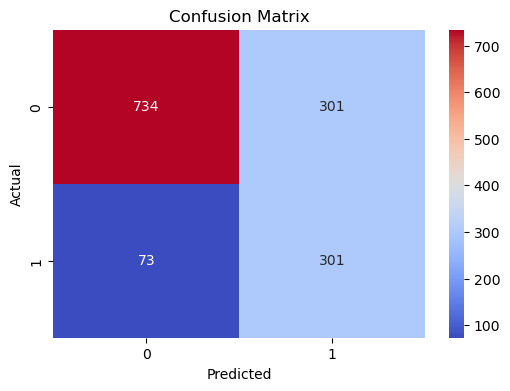

✓ Predictions complete!


In [7]:
# --------------------------
# LOGISTIC REGRESSION MODEL
# --------------------------
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
logreg.fit(X_train, y_train)

# --------------------------
# PREDICTIONS + PROBABILITIES
# --------------------------
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# --------------------------
# MODEL PERFORMANCE
# --------------------------
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print(f"✓ Precision: {precision_score(y_test, y_pred):.3f}")
print(f"✓ Recall: {recall_score(y_test, y_pred):.3f}")
print(f"✓ F1-Score: {f1_score(y_test, y_pred):.3f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("✓ Predictions complete!")



✓ Top 10 High-Risk Users
      customerid  churn_probability risk_level  monthlycharges
3380  5178-LMXOP          97.307913  High Risk           95.10
1976  9497-QCMMS          97.218740  High Risk           93.55
4800  9300-AGZNL          97.198998  High Risk           94.00
2208  7216-EWTRS          97.194679  High Risk          100.80
3209  8149-RSOUN          96.687476  High Risk           93.85
6866  0295-PPHDO          96.685792  High Risk           95.45
2577  4910-GMJOT          96.648414  High Risk           94.60
6482  5419-JPRRN          96.614991  High Risk          101.45
2745  4826-XTSOH          96.403636  High Risk           86.05
1600  3068-OMWZA          96.305694  High Risk           88.80


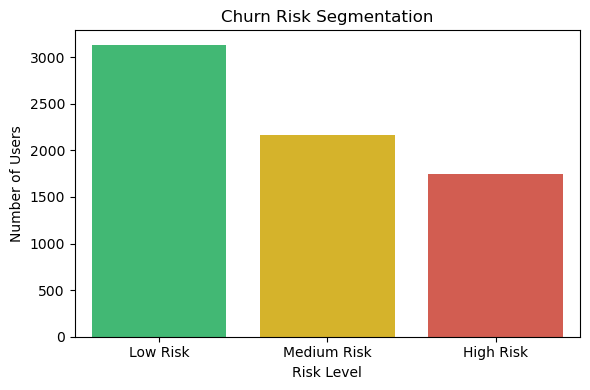

In [8]:
# -----------------------------
# CHURN RISK SEGMENTATION
# -----------------------------
# Predict probabilities for all customers
X_scaled_all = X.copy()
X_scaled_all[num_cols] = scaler.transform(X_scaled_all[num_cols])
df['churn_probability'] = logreg.predict_proba(X_scaled_all)[:, 1] * 100  # percentage

# Define risk levels
df['risk_level'] = pd.cut(
    df['churn_probability'],
    bins=[0, 30, 70, 100],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Top 10 high-risk users
high_risk_users = df[df['risk_level'] == 'High Risk'].sort_values(by='churn_probability', ascending=False)
print("\n" + "="*50)
print("✓ Top 10 High-Risk Users")
print("="*50)
print(high_risk_users.head(10)[['customerid','churn_probability','risk_level','monthlycharges']])

# Visualize risk segmentation
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='risk_level', order=['Low Risk','Medium Risk','High Risk'],
              palette=['#2ecc71','#f1c40f','#e74c3c'])
plt.title('Churn Risk Segmentation')
plt.ylabel('Number of Users')
plt.xlabel('Risk Level')
plt.tight_layout()
plt.show()


In [9]:
# -----------------------------
# ADD PREDICTED CHURN COLUMN
# -----------------------------
# Predict churn for all customers (0 = No, 1 = Yes)
df['predicted_churn'] = logreg.predict(X_scaled_all)

# Convert to "Yes"/"No" format to match original churn column
df['predicted_churn_label'] = df['predicted_churn'].map({0: 'No', 1: 'Yes'})

# Show prediction accuracy on full dataset
print("\n" + "="*50)
print("PREDICTION SUMMARY")
print("="*50)
print(f"Total Customers: {len(df)}")
print(f"Predicted to Churn: {df['predicted_churn'].sum()} ({df['predicted_churn'].mean()*100:.1f}%)")
print(f"Predicted to Stay: {(df['predicted_churn']==0).sum()} ({(df['predicted_churn']==0).mean()*100:.1f}%)")

# Compare actual vs predicted
comparison = pd.crosstab(df['churn'], df['predicted_churn_label'], 
                         rownames=['Actual'], colnames=['Predicted'])
#print("\nActual vs Predicted:")
print("\nActual vs Predicted (0=No, 1=Yes):")
print(comparison)

# Calculate overall accuracy on full dataset
full_accuracy = (df['churn'] == df['predicted_churn']).mean()
print(f"\nOverall Prediction Accuracy: {full_accuracy*100:.2f}%")


# Show some example predictions
print("\nSample Predictions:")
print(df[['customerid', 'churn', 'predicted_churn_label', 'churn_probability', 'risk_level']].head(10))



PREDICTION SUMMARY
Total Customers: 7043
Predicted to Churn: 2919 (41.4%)
Predicted to Stay: 4124 (58.6%)

Actual vs Predicted (0=No, 1=Yes):
Predicted    No   Yes
Actual               
0          3771  1403
1           353  1516

Overall Prediction Accuracy: 75.07%

Sample Predictions:
   customerid  churn predicted_churn_label  churn_probability   risk_level
0  7590-VHVEG      0                   Yes          89.065088    High Risk
1  5575-GNVDE      0                    No           9.838766     Low Risk
2  3668-QPYBK      1                   Yes          54.051683  Medium Risk
3  7795-CFOCW      0                    No          10.712477     Low Risk
4  9237-HQITU      1                   Yes          85.636088    High Risk
5  9305-CDSKC      1                   Yes          91.052325    High Risk
6  1452-KIOVK      0                   Yes          69.884036  Medium Risk
7  6713-OKOMC      0                    No          39.817694  Medium Risk
8  7892-POOKP      1                


TOP 15 FEATURES DRIVING CHURN
                       Feature  Importance
             contract_Two year    1.593777
   internetservice_Fiber optic    1.228065
                monthlycharges    0.738245
             contract_One year    0.705920
        tenuregroup_24+ months    0.618304
             avg_monthly_spend    0.516140
      tenuregroup_12-24 months    0.447402
           streamingmovies_Yes    0.445281
             price_sensitivity    0.441329
               streamingtv_Yes    0.428968
             multiplelines_Yes    0.405337
paymentmethod_Electronic check    0.367094
          paperlessbilling_Yes    0.338909
            onlinesecurity_Yes    0.282635
                  totalcharges    0.277126


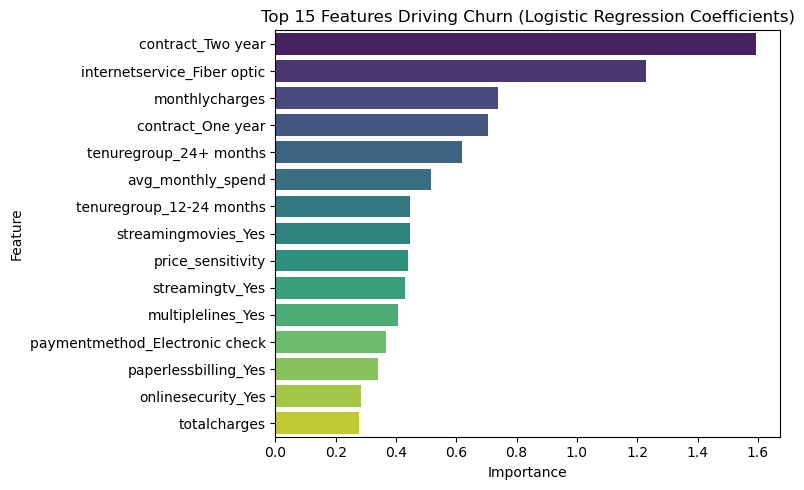

In [10]:
# -----------------------------
# FEATURE IMPORTANCE (Logistic Regression)
# -----------------------------
print("\n" + "="*50)
print("TOP 15 FEATURES DRIVING CHURN")
print("="*50)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(logreg.coef_[0])
}).sort_values(by='Importance', ascending=False)

print(importances.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Features Driving Churn (Logistic Regression Coefficients)")
plt.tight_layout()
plt.show()


In [11]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,churn,signupdate,churndate,avg_monthly_spend,price_sensitivity,tenuregroup,churn_probability,risk_level,predicted_churn,predicted_churn_label
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,0,2024-12-01,NaT,14.925000,2.000000,0-6 months,89.065088,High Risk,1,Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,0,2023-01-01,NaT,53.985714,1.054909,24+ months,9.838766,Low Risk,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,1,2024-11-01,2024-12-31,36.050000,1.493759,0-6 months,54.051683,Medium Risk,1,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,0,2023-01-01,NaT,40.016304,1.057069,24+ months,10.712477,Low Risk,0,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,1,2024-11-01,2024-12-31,50.550000,1.398615,0-6 months,85.636088,High Risk,1,Yes


In [13]:
# ============================================================================
# EXPORT DATA TO CSV
# ============================================================================

import os

# Create directories
export_dir = "exported_data"
os.makedirs(export_dir, exist_ok=True)
tableau_dir = r"C:\Users\hp\Desktop\folder for data output"
os.makedirs(tableau_dir, exist_ok=True)

# 1️⃣ Save full dataset with predictions and risk levels
full_data_path = os.path.join(tableau_dir, "churn_predictions_full.csv")
df.to_csv(full_data_path, index=False)


# 3️⃣ Save feature importance to Tableau output folder
feature_importance_path = os.path.join(tableau_dir, "feature_importance1.csv")
importances.to_csv(feature_importance_path, index=False)


# 4️⃣ Save a Tableau-ready master dataset
tableau_file = os.path.join(tableau_dir, "churn_master_data.csv")
df.to_csv(tableau_file, index=False)
print("\n" + "="*50)
print("✅ Data Exported! Ready for Tableau!")
print("="*50)
print(f"✓ Feature importance saved to: {feature_importance_path}")
print(f"✓ Full dataset with predictions saved to: {full_data_path}")

print(f"\nFile saved: {tableau_file}")
print(f"Columns exported: {len(df.columns)}")



✅ Data Exported! Ready for Tableau!
✓ Feature importance saved to: C:\Users\hp\Desktop\folder for data output\feature_importance1.csv
✓ Full dataset with predictions saved to: C:\Users\hp\Desktop\folder for data output\churn_predictions_full.csv

File saved: C:\Users\hp\Desktop\folder for data output\churn_master_data.csv
Columns exported: 30
